# KoELECTRA 모델링

## 1. 데이터 전처리

In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import re
from soynlp.normalizer import repeat_normalize

# 데이터 로드
train_df = pd.read_csv('../../data/train.csv')
general_df = pd.read_csv('../../data/train_daily.csv')

# 데이터 합치기
df = pd.concat([train_df, general_df], ignore_index=True)

# 중복 제거
print(f'중복 제거 전 데이터 크기: {len(df)}')
df.drop_duplicates(subset=['conversation'], keep='first', inplace=True, ignore_index=True)
print(f'중복 제거 후 데이터 크기: {len(df)}')

# 클래스 매핑
class_mapping = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}
df['class'] = df['class'].map(class_mapping)

def preprocess_text(text):
    # 1. 반복되는 문자 정규화
    text = repeat_normalize(text, num_repeats=2)

    # 2. 특수문자 처리
    # 의미있는 특수문자는 보존하고 나머지는 제거
    text = re.sub(r'[^가-힣ㄱ-ㅎㅏ-ㅣ\s\.,!?~()]', '', text)

    # 3. 여러 개의 공백을 하나로
    text = re.sub(r'\s+', ' ', text)

    # 4. 앞뒤 공백 제거
    text = text.strip()

    return text

# 전처리 적용
print("텍스트 전처리 적용 중...")
df['conversation'] = df['conversation'].apply(preprocess_text)

print("Combined DataFrame Head:")
display(df.head())
print("\nClass Distribution:")
print(df['class'].value_counts().sort_index())

중복 제거 전 데이터 크기: 4850
중복 제거 후 데이터 크기: 4744
텍스트 전처리 적용 중...
Combined DataFrame Head:


,idx,class,conversation
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...
1,1,0,길동경찰서입니다. 시 분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만 더 ...
2,2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없...
3,3,1,어이 거기 예?? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈...
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...



Class Distribution:
class
0     892
1     973
2     970
3    1011
4     898
Name: count, dtype: int64



전처리 전후 비교 (처음 5개 샘플):

[예시 1]
전처리 전: 지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해? 진짜 죽여버리고 싶게. 정말 잘못했습니다. 너가 선택해. 너가 죽을래 네 가족을 죽여줄까. 죄송합니다. 정말 잘못했습니다. 너에게는 선택권이 없어. 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야. 선택 못하겠습니다. 한번만 도와주세요. 그냥 다 죽여버려야겠군. 이의 없지? 제발 도와주세요.
전처리 후: 지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해? 진짜 죽여버리고 싶게. 정말 잘못했습니다. 너가 선택해. 너가 죽을래 네 가족을 죽여줄까. 죄송합니다. 정말 잘못했습니다. 너에게는 선택권이 없어. 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야. 선택 못하겠습니다. 한번만 도와주세요. 그냥 다 죽여버려야겠군. 이의 없지? 제발 도와주세요.

[예시 2]
전처리 전: 길동경찰서입니다. 시 분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만 더 얘기한다. 장난전화 걸지 마시죠. 시 분 마트에 폭발물이 터지면 다 죽는거야. 장난전화는 업무방해죄에 해당됩니다. 판단은 너에게 달려있다. 길동경찰서에도 폭발물 터지면 꽤나 재미있겠지. 선생님 진정하세요. 난 이야기했어. 경고했다는 말이야.
전처리 후: 길동경찰서입니다. 시 분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만 더 얘기한다. 장난전화 걸지 마시죠. 시 분 마트에 폭발물이 터지면 다 죽는거야. 장난전화는 업무방해죄에 해당됩니다. 판단은 너에게 달려있다. 길동경찰서에도 폭발물 터지면 꽤나 재미있겠지. 선생님 진정하세요. 난 이야기했어. 경고했다는 말이야.

[예시 3]
전처리 전: 너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없어. 지영아 너가 키 이지? 그럼 재는 도 안돼는거네? 너 군대도 안가고 좋

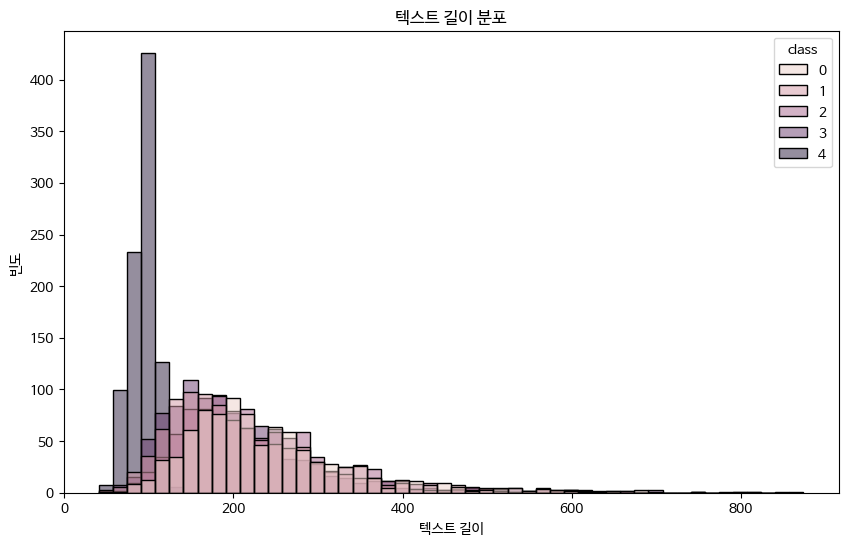


클래스별 텍스트 길이 통계:

클래스 0:
count    892.000000
mean     243.451794
std      105.419226
min       57.000000
25%      173.000000
50%      218.000000
75%      285.000000
max      818.000000
Name: text_length, dtype: float64

클래스 1:
count    973.000000
mean     212.760534
std       98.512816
min       45.000000
25%      145.000000
50%      188.000000
75%      259.000000
max      664.000000
Name: text_length, dtype: float64

클래스 2:
count    970.000000
mean     235.214433
std      103.562395
min       41.000000
25%      166.000000
50%      214.000000
75%      280.000000
max      842.000000
Name: text_length, dtype: float64

클래스 3:
count    1011.000000
mean      210.837784
std       106.146972
min        41.000000
25%       143.000000
50%       186.000000
75%       247.000000
max       874.000000
Name: text_length, dtype: float64

클래스 4:
count    898.000000
mean      93.811804
std       14.577712
min       45.000000
25%       84.000000
50%       97.000000
75%      104.000000
max      135.000000

In [2]:
# 텍스트 길이 분포 확인
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

# 텍스트 길이 계산
df['text_length'] = df['conversation'].str.len()

df['conversation_preprocessed'] = df['conversation'].apply(preprocess_text)

# 전처리 전후 비교 예시 출력
print("\n전처리 전후 비교 (처음 5개 샘플):")
for i in range(5):
    print(f"\n[예시 {i+1}]")
    print(f"전처리 전: {df['conversation'].iloc[i]}")
    print(f"전처리 후: {df['conversation_preprocessed'].iloc[i]}")

# 전처리된 텍스트 길이 분포 확인
df['preprocessed_length'] = df['conversation_preprocessed'].str.len()
print("\n전처리 후 텍스트 길이 통계:")
print(df['preprocessed_length'].describe())

# MAX_LEN 설정을 위한 분위수 확인
print("\n텍스트 길이 분위수:")
print(df['preprocessed_length'].quantile([0.5, 0.8, 0.9, 0.95, 0.99]))

# 텍스트 길이 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', hue='class', bins=50)
plt.title('텍스트 길이 분포')
plt.xlabel('텍스트 길이')
plt.ylabel('빈도')
plt.show()

# 클래스별 텍스트 길이 통계
print("\n클래스별 텍스트 길이 통계:")
for class_idx in sorted(df['class'].unique()):
    lengths = df[df['class'] == class_idx]['text_length']
    print(f"\n클래스 {class_idx}:")
    print(lengths.describe())

클래스별 텍스트 길이 통계:

클래스 0:
count    892.000000
mean     243.451794
std      105.419226
min       57.000000
25%      173.000000
50%      218.000000
75%      285.000000
max      818.000000
Name: preprocessed_length, dtype: float64

클래스 1:
count    973.000000
mean     212.760534
std       98.512816
min       45.000000
25%      145.000000
50%      188.000000
75%      259.000000
max      664.000000
Name: preprocessed_length, dtype: float64

클래스 2:
count    970.000000
mean     235.214433
std      103.562395
min       41.000000
25%      166.000000
50%      214.000000
75%      280.000000
max      842.000000
Name: preprocessed_length, dtype: float64

클래스 3:
count    1011.000000
mean      210.837784
std       106.146972
min        41.000000
25%       143.000000
50%       186.000000
75%       247.000000
max       874.000000
Name: preprocessed_length, dtype: float64

클래스 4:
count    898.000000
mean      93.811804
std       14.577712
min       45.000000
25%       84.000000
50%       97.000000
75%     

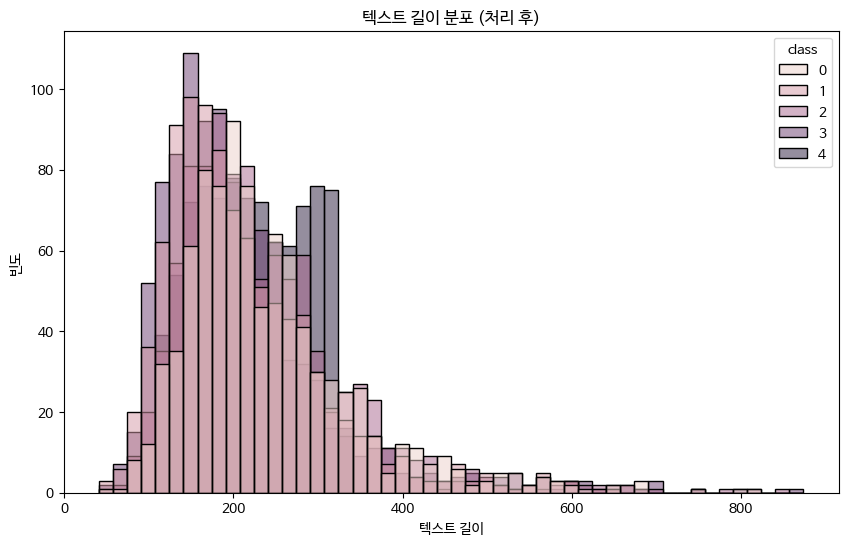

In [3]:
# 텍스트 길이 불균형 처리
print("클래스별 텍스트 길이 통계:")
for class_idx in sorted(df['class'].unique()):
    lengths = df[df['class'] == class_idx]['preprocessed_length']
    print(f"\n클래스 {class_idx}:")
    print(lengths.describe())

# 클래스별 평균과 표준편차 계산 (클래스 4 제외)
non_general_lengths = df[df['class'] != 4]['preprocessed_length']
target_mean = non_general_lengths.mean()
target_std = non_general_lengths.std()

# 목표 길이 범위 설정
min_target = int(target_mean - target_std)  # 더 넓은 범위 설정
max_target = int(target_mean + target_std)
print(f"\n목표 텍스트 길이 범위: {min_target} ~ {max_target}")

import random

def augment_short_text(text):
    """짧은 텍스트를 다양한 길이로 증강"""
    words = text.split()
    base_text = ' '.join(words)

    # 목표 길이를 범위 내에서 랜덤하게 선택
    target_length = random.randint(min_target, max_target)

    if len(base_text) >= target_length:
        return base_text

    # 텍스트를 반복하되, 다양한 길이로 생성
    result = []
    while len(' '.join(result)) < target_length:
        # 랜덤하게 단어 그룹 선택 (다양성을 위해)
        group_size = random.randint(1, len(words))
        selected_words = words[:group_size]
        result.extend(selected_words)

    # 목표 길이에 최대한 근접하도록 조정
    while len(' '.join(result)) > target_length:
        result.pop()

    return ' '.join(result)

# 텍스트 길이 균형 맞추기
balanced_texts = []
balanced_labels = []

for idx, row in df.iterrows():
    text = row['conversation_preprocessed']
    label = row['class']

    if label == 4:  # 일반 대화 처리
        augmented_text = augment_short_text(text)
        balanced_texts.append(augmented_text)
        balanced_labels.append(label)
    else:
        balanced_texts.append(text)
        balanced_labels.append(label)

# 새로운 균형 데이터셋 생성
balanced_df = pd.DataFrame({
    'conversation': balanced_texts,
    'class': balanced_labels
})

# 클래스별 텍스트 길이 통계 확인
print("\n처리 후 클래스별 텍스트 길이 통계:")
for class_idx in sorted(balanced_df['class'].unique()):
    lengths = balanced_df['conversation'].str.len()
    class_lengths = lengths[balanced_df['class'] == class_idx]
    print(f"\n클래스 {class_idx}:")
    print(class_lengths.describe())

# 텍스트 길이 분포 시각화 (처리 후)
plt.figure(figsize=(10, 6))
sns.histplot(data=balanced_df, x=balanced_df['conversation'].str.len(), hue='class', bins=50)
plt.title('텍스트 길이 분포 (처리 후)')
plt.xlabel('텍스트 길이')
plt.ylabel('빈도')
plt.show()

# 수정된 데이터로 훈련/검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(
    balanced_df['conversation'].to_list(),
    balanced_df['class'].to_list(),
    test_size=0.2,
    random_state=42,
    stratify=balanced_df['class'].to_list()
)

## 2. 모델 및 토크나이저 로드

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

MODEL_NAME = "monologg/koelectra-base-v3-discriminator"

# 드롭아웃을 적용하기 위해 모델 설정을 변경합니다.
config = AutoConfig.from_pretrained(MODEL_NAME)
config.hidden_dropout_prob = 0.1

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=5)

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
model.to("mps")
print(f'Using device: {device}')
print(f'Dropout probability: {model.config.hidden_dropout_prob}')

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: mps
Dropout probability: 0.1


## 3. 데이터셋 및 데이터로더 생성

In [5]:
# 데이터 분할
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['conversation'].tolist(),
    df['class'].tolist(),  # encoded_class 대신 class 사용
    test_size=0.2,
    random_state=42,
    stratify=df['class'].tolist()  # encoded_class 대신 class 사용
)

# 토크나이징
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)  # max_length 증가
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=256)  # max_length 증가

# PyTorch 데이터셋 클래스
class DKTCDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# 데이터셋 생성
train_dataset = DKTCDataset(train_encodings, train_labels)
val_dataset = DKTCDataset(val_encodings, val_labels)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

Training set size: 3795
Validation set size: 949


## 4. 모델 학습 및 평가

In [7]:
import torch.optim as optim
from sklearn.metrics import f1_score, classification_report
import numpy as np
from transformers import get_linear_schedule_with_warmup
import copy

# EarlyStopping 클래스 정의
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=3, verbose=False, delta=0, path='best_model_state.bin', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 3
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'best_model_state.bin'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def train_model(model, dataloader, optimizer, scheduler):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Gradient Clipping
        optimizer.step()
        scheduler.step() # Update learning rate

    return total_loss / len(dataloader)

def evaluate_model(model, dataloader, conversations, class_mapping=None):
    model.eval()
    total_loss = 0
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    avg_val_loss = total_loss / len(dataloader)

    if len(conversations) != len(true_labels):
        raise ValueError("텍스트 데이터와 라벨 데이터의 길이가 일치하지 않습니다!")

    weighted_f1 = f1_score(true_labels, predictions, average='weighted')
    report = classification_report(true_labels, predictions, target_names=[k for k, v in sorted(class_mapping.items(), key=lambda item: item[1])])

    error_df = pd.DataFrame({
        'conversation': conversations,
        'true_label': true_labels,
        'predicted_label': predictions
    })

    reverse_class_mapping = {v: k for k, v in class_mapping.items()}
    error_df['true_label_name'] = error_df['true_label'].map(reverse_class_mapping)
    error_df['predicted_label_name'] = error_df['predicted_label'].map(reverse_class_mapping)

    misclassified = error_df[error_df['true_label'] != error_df['predicted_label']].copy()

    return avg_val_loss, weighted_f1, report, misclassified

# --- 학습 설정 ---
epochs = 10  # 최대 Epoch 수 (조기 종료될 수 있음)
patience = 1  # 2 epoch 동안 성능 개선이 없으면 조기 종료
learning_rate = 2e-5
weight_decay = 0.01

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value
                                            num_training_steps = total_steps)

early_stopping = EarlyStopping(patience=patience, verbose=True)

# --- 학습 루프 ---
for epoch in range(epochs):
    print(f'======== Epoch {epoch + 1} / {epochs} ========')
    train_loss = train_model(model, train_loader, optimizer, scheduler)
    val_loss, weighted_f1, class_report, misclassified = evaluate_model(model, val_loader, val_texts, class_mapping=class_mapping)

    print(f'Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f} | Validation Weighted F1: {weighted_f1:.4f}')

    # Early stopping 확인
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# --- 최종 평가 ---
print("\n--- 최종 평가 (Best Model) ---")
# 가장 성능이 좋았던 모델의 가중치를 로드
model.load_state_dict(torch.load('best_model_state.bin'))

# 최종 평가 실행
final_loss, final_f1, final_report, final_misclassified = evaluate_model(model, val_loader, val_texts, class_mapping=class_mapping)

print(f"Final Validation Loss: {final_loss:.4f}")
print(f"Final Validation Weighted F1: {final_f1:.4f}")
print("Final Classification Report:")
print(final_report)

# 최종 오분류 데이터 저장
print(f'\\n총 {len(final_misclassified)}개의 오분류 데이터 발견')
final_misclassified.to_csv('misclassified_output_final.csv', index=False)
display(final_misclassified.head())

======== Epoch 1 / 10 ========
Train Loss: 0.9321 | Validation Loss: 0.4008 | Validation Weighted F1: 0.8865
Validation loss decreased (inf --> 0.400778).  Saving model ...
======== Epoch 2 / 10 ========
Train Loss: 0.3331 | Validation Loss: 0.2962 | Validation Weighted F1: 0.9041
Validation loss decreased (0.400778 --> 0.296232).  Saving model ...
======== Epoch 3 / 10 ========
Train Loss: 0.1896 | Validation Loss: 0.3307 | Validation Weighted F1: 0.9161
EarlyStopping counter: 1 out of 1
Early stopping

--- 최종 평가 (Best Model) ---
Final Validation Loss: 0.2962
Final Validation Weighted F1: 0.9041
Final Classification Report:
              precision    recall  f1-score   support

       협박 대화       0.82      0.89      0.85       178
       갈취 대화       0.87      0.88      0.88       195
 직장 내 괴롭힘 대화       0.95      0.94      0.95       194
   기타 괴롭힘 대화       0.88      0.82      0.85       202
       일반 대화       1.00      1.00      1.00       180

    accuracy                           0.

,conversation,true_label,predicted_label,true_label_name,predicted_label_name
0,이거 도와주세요. 난 지금 바빠서 도와줄 시간이 없어. 넌 바쁠 때 항상 바쁜척 하...,0,3,협박 대화,기타 괴롭힘 대화
20,어이 아가씨!! 저 아세요.? 이쁜데 어디 살아? 저리 가세요. 아 비싸게 굴지 말...,3,1,기타 괴롭힘 대화,갈취 대화
40,여기 다른 직원 좀 불러주세요 네 무슨 일이시죠? 아까 분명 사과개 만원이라고 했는...,3,1,기타 괴롭힘 대화,갈취 대화
44,저기요 저 치킨 배달 시켰는데 치킨 좀 받아와 주세요 보다시피 제가 발에 깁스를 하...,0,3,협박 대화,기타 괴롭힘 대화
45,중구가 시키드나? 경찰들 논간에 놀아나는 거여 어이 정청 이 짱개새꺄 우리가 개 호...,0,3,협박 대화,기타 괴롭힘 대화


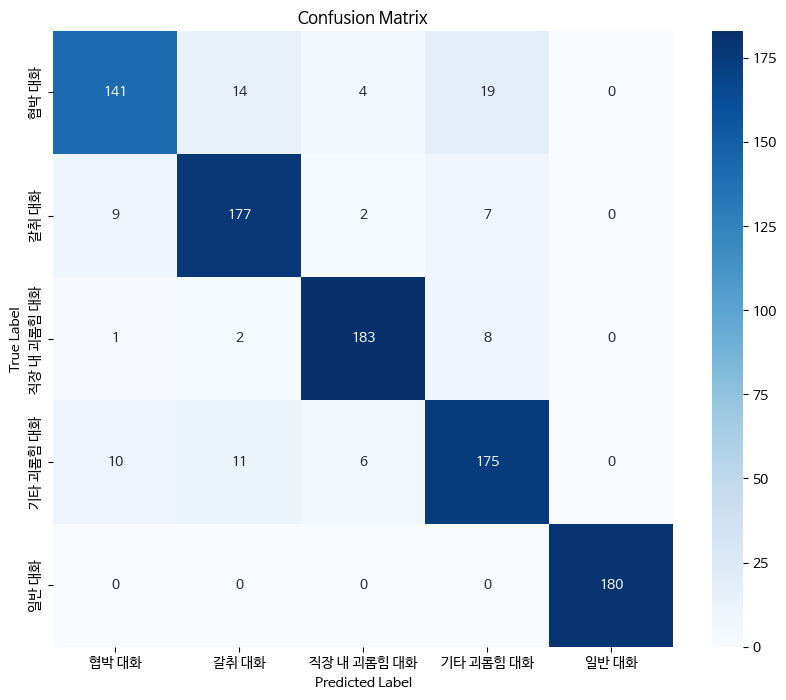

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Generates and plots a confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# --- Confusion Matrix 생성을 위한 예측 ---
# 저장된 최적의 모델 가중치를 불러옵니다.
model.load_state_dict(torch.load('best_model_state.bin', map_location=torch.device('mps')))
model.eval()

all_predictions = []
all_true_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        all_predictions.extend(preds)
        all_true_labels.extend(labels.cpu().numpy())

# 클래스 이름 순서대로 가져오기
class_names = [name for name, num in sorted(class_mapping.items(), key=lambda item: item[1])]

# 혼동 행렬 시각화
plot_confusion_matrix(all_true_labels, all_predictions, class_names)

In [10]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

# --- 1. 테스트 데이터 로드 및 전처리 ---
# 테스트 데이터 로드
test_df = pd.read_csv('../../data/test.csv')

# 'text' 컬럼에 대해 훈련 시 사용했던 동일한 전처리 함수 적용
# (만약 preprocess_text 함수가 다른 셀에 정의되어 있다면, 이 셀에서 다시 정의하거나 해당 셀을 먼저 실행해야 합니다.)
test_df['text'] = test_df['text'].apply(preprocess_text)
print("Test data loaded and preprocessed.")


# --- 2. 테스트 데이터셋 및 데이터로더 생성 ---
class TestDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=256):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }

# 'text' 컬럼을 사용하여 테스트 데이터셋 생성
test_dataset = TestDataset(test_df['text'], tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
print("Test dataset and dataloader created.")


# --- 3. 모델 로드 및 예측 수행 ---
# 저장된 최적의 모델 가중치를 불러옵니다.
model.load_state_dict(torch.load('best_model_state.bin', map_location=torch.device('mps')))
model.to(device)
model.eval()

all_predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_predictions.extend(preds)

print("Prediction finished.")


# --- 4. 제출 파일 생성 ---
# 제출용 DataFrame 생성 (class를 숫자로 유지)
submission_df = pd.DataFrame({
    'idx': test_df['idx'],
    'class': all_predictions
})

# CSV 파일로 저장
submission_df.to_csv('submission.csv', index=False)

print("\n'submission.csv' file has been created successfully!")
display(submission_df.head())

Test data loaded and preprocessed.
Test dataset and dataloader created.
Prediction finished.

'submission.csv' file has been created successfully!


,idx,class
0,t_000,1
1,t_001,2
2,t_002,2
3,t_003,4
4,t_004,2
